In [11]:
import pandas as pd
pd.set_option('display.max_rows', 15)  # or use a specific number
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import math
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold

**EDA** PREDICTING PULMONARY EDEMA

In [12]:
from ucimlrepo import fetch_ucirepo 
pd.set_option('display.max_rows', None)
  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
df = myocardial_infarction_complications.data.original 
X_full = myocardial_infarction_complications.data.features[:] 
y_full = myocardial_infarction_complications.data.targets[:] 

X = X_full[:]
y = y_full[:]
  
# metadata 
#print(myocardial_infarction_complications.metadata) 
  
# variable information 
vars = myocardial_infarction_complications.variables


In [13]:
print(vars[vars['role']=='Target'])

           name    role         type demographic  \
112  FIBR_PREDS  Target       Binary        None   
113   PREDS_TAH  Target       Binary        None   
114   JELUD_TAH  Target       Binary        None   
115  FIBR_JELUD  Target       Binary        None   
116    A_V_BLOK  Target       Binary        None   
117   OTEK_LANC  Target       Binary        None   
118      RAZRIV  Target       Binary        None   
119    DRESSLER  Target       Binary        None   
120         ZSN  Target       Binary        None   
121      REC_IM  Target       Binary        None   
122   P_IM_STEN  Target       Binary        None   
123      LET_IS  Target  Categorical        None   

                                                                                                                                                                                                                            description  \
112                                                                                     

In [14]:
##FIND NUMBER OF EACH TARGET VARIABLE
#note, from metadata we know that there are no missing values in the target variables
print('y==1')
print((y == 1).sum())
# print('--')
# print('y==0')
# print((y == 0).sum())

#(y == 1).sum()/((y == 0).sum()+(y==1).sum())

y==1
FIBR_PREDS    170
PREDS_TAH      20
JELUD_TAH      42
FIBR_JELUD     71
A_V_BLOK       57
OTEK_LANC     159
RAZRIV         54
DRESSLER       75
ZSN           394
REC_IM        159
P_IM_STEN     148
LET_IS        110
dtype: int64


In [15]:
names_binary_feats = np.array(vars[(vars['type']=='Binary') & (vars['role']=='Feature')].name)
names_cat_feats = np.array(vars[(vars['type']=='Categorical') & (vars['role']=='Feature')].name)
names_int_feats = np.array(vars[(vars['type']=='Integer') & (vars['role']=='Feature')].name)
names_cont_feats = np.array(vars[(vars['type']=='Continuous') & (vars['role']=='Feature')].name)


In [16]:
# pd.set_option('display.max_rows', None)  # or use a specific number
# pd.set_option('display.max_columns', None)

# feature_names = vars[(vars['type'] == 'Binary') & (vars['role'] == 'Feature')]['name'].tolist()
# print(feature_names)

# feature_data = vars[vars['role'] == 'Feature'][['description', 'name', 'type']]
# feature_data.to_csv('feature_names.csv', index=True)
# col_headers = vars[vars['role']=='Feature'].description
# list_headers = [x for x in col_headers]
# print(list_headers)

# col_headers = vars[vars['role']=='Target'].description
# list_headers = [x for x in col_headers]
# print(list_headers)

#print(vars[['name','description','type']])

pd.set_option('display.max_rows', 15)  # or use a specific number



In [17]:
pd.set_option('display.max_colwidth', None)
target_names = np.array(vars.loc[vars['role']=='Target'].name)
#vars.loc[vars['name']=='OTEK_LANC']
#y.value_counts()
y['OTEK_LANC'].value_counts()

OTEK_LANC
0    1541
1     159
Name: count, dtype: int64

<Axes: xlabel='REC_IM', ylabel='K_BLOOD'>

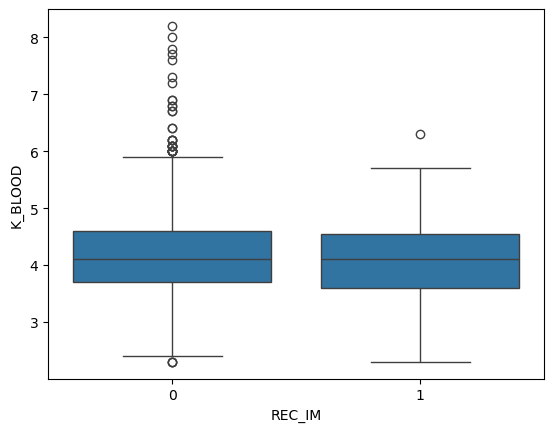

In [18]:
sns.boxplot(x='REC_IM', y='K_BLOOD', data=df)


**SPLITTING DATA**



In [19]:
random_state = 42

def basic_split(X,y,train_size,val_size,test_size,random_state):
    #tests inputs
    if train_size+val_size+test_size==1:
        print("the sizes sum to 1")
    else:
        print("error: the sizes sum to", train_size+val_size+test_size)
    
    if isinstance(random_state, int):
        print("random state is an integer")
    else:
        print("error: random state is not an integer")

    
    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y, train_size=train_size,random_state = random_state)
    
    TestSize = test_size/(test_size+val_size)
    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,test_size=TestSize,random_state = random_state)

    #tests outputs
    X_size = X.shape[0]
    y_size = y.shape[0]
    tolerance=0.01

    if math.isclose(X_train.shape[0]/X_size,train_size,rel_tol=tolerance):
        print("X_train is the correct size!")
    else:
        print("error: X_train is of size", X_train.shape[0]/X_size)
    
    if math.isclose(X_val.shape[0]/X_size,val_size,rel_tol=tolerance):
        print("X_train is the correct size!")
    else:
        print("error: X_val is of size", X_val.shape[0]/X_size)

    if math.isclose(X_test.shape[0]/X_size,test_size,rel_tol=tolerance):
        print("X_train is the correct size!")
    else:
        print("error: X_test is of size", X_test.shape[0]/X_size)
    
    if math.isclose(y_train.shape[0]/y_size,train_size,rel_tol=tolerance):
        print("y_train is the correct size!")
    else:
        print("error: y_train is of size", y_train.shape[0]/y_size)
    
    if math.isclose(y_val.shape[0]/y_size, val_size,rel_tol=tolerance):
        print("y_train is the correct size!")
    else:
        print("error: y_val is of size", y_val.shape[0]/y_size)

    if math.isclose(y_test.shape[0]/y_size,test_size,rel_tol=tolerance):
        print("y_train is the correct size!")
    else:
        print("error: y_test is of size", y_test.shape[0]/y_size)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [20]:
onehot_ftrs = np.concatenate((names_binary_feats, ['ant_im', 'lat_im', 'inf_im', 'post_im']))
# note: ordinal features are already in order in the given dataset
ordinal_ftrs = np.concatenate((np.setdiff1d(names_cat_feats, ['ant_im', 'lat_im', 'inf_im', 'post_im']), ['NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n', 'NOT_NA_2_n', 'NOT_NA_3_n']))
minmax_ftrs = ['AGE', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT']
std_ftrs = names_cont_feats

# Combine all feature arrays into one
all_ftrs = np.concatenate((onehot_ftrs, ordinal_ftrs, minmax_ftrs, std_ftrs))

# Convert feature_names to a NumPy array
feature_names_array = np.array(feature_names)

# Checking to make sure everything worked
    # Find values in feature_names_array that are not in all_ftrs
not_in_features = np.setdiff1d(feature_names_array, all_ftrs)

print(not_in_features) #worked! returned no values

    # Find duplicates
duplicates = set()
for i in range(len(all_ftrs)):
    for j in range(i + 1, len(all_ftrs)):
        common = np.intersect1d(all_ftrs[i], all_ftrs[j])
        duplicates.update(common)

print(np.array(list(duplicates))) #worked! no duplicates

[]
[]


**MISSING VALUES**

In [30]:
# Find fraction of NaNs
X_nan_number = X.isna().sum().sort_values(ascending=False)
X_nan_percentage = X_nan_number/1700

print(X_nan_number)
print(X_nan_percentage>0.5)

missing_rows = X[X[np.concatenate([std_ftrs.tolist(), minmax_ftrs])].isnull()]
print(missing_rows.shape) # Every row has at least one missing value


KFK_BLOOD     1696
IBS_NASL      1628
D_AD_KBRIG    1076
S_AD_KBRIG    1076
NOT_NA_KB      686
              ... 
zab_leg_04       7
NA_R_1_n         5
INF_ANAM         4
IM_PG_P          1
SEX              0
Length: 111, dtype: int64
KFK_BLOOD      True
IBS_NASL       True
D_AD_KBRIG     True
S_AD_KBRIG     True
NOT_NA_KB     False
              ...  
zab_leg_04    False
NA_R_1_n      False
INF_ANAM      False
IM_PG_P       False
SEX           False
Length: 111, dtype: bool
(1700, 111)


In [22]:
# Calculate the number of NaNs in the combined features
X_nan_number = X[np.concatenate([std_ftrs, minmax_ftrs])].isna().sum().sort_values(ascending=False)

# Calculate the percentage of NaNs
X_nan_percentage = X_nan_number / len(X)  # Assuming len(X) gives the number of rows

# Create a DataFrame to combine both metrics
nan_df = pd.DataFrame({
    'NaN Count': X_nan_number,
    'NaN Percentage': X_nan_percentage
})

# Include descriptions from vars DataFrame
nan_df['Description'] = nan_df.index.map(lambda col: vars.loc[vars['name'] == col, 'description'].values[0] if not vars.loc[vars['name'] == col, 'description'].empty else None)

nan_df

,NaN Count,NaN Percentage,Description
KFK_BLOOD,1696,0.997647,Serum CPK content
S_AD_KBRIG,1076,0.632941,Systolic blood pressure according to Emergency Cardiology Team
D_AD_KBRIG,1076,0.632941,Diastolic blood pressure according to Emergency Cardiology Team
NA_BLOOD,375,0.220588,Serum sodium content
K_BLOOD,371,0.218235,Serum potassium content
AST_BLOOD,285,0.167647,Serum AsAT content
ALT_BLOOD,284,0.167059,Serum AlAT content (ALT_BLOOD)
S_AD_ORIT,267,0.157059,Systolic blood pressure according to intensive care unit
D_AD_ORIT,267,0.157059,Diastolic blood pressure according to intensive care unit
ROE,203,0.119412,ESR (Erythrocyte sedimentation rate)


In [23]:
#change ordinal and categorical values into strings
X[ordinal_ftrs] = X[ordinal_ftrs].astype(str)
X[onehot_ftrs] = X[onehot_ftrs].astype(str)
X.replace('nan', np.nan, inplace=True)

X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X,y,train_size=0.6,val_size=0.2,test_size=0.2, random_state=random_state) 

the sizes sum to 1
random state is an integer
X_train is the correct size!
X_train is the correct size!
X_train is the correct size!
y_train is the correct size!
y_train is the correct size!
y_train is the correct size!


In [24]:
# Convert feature arrays to lists for compatibility; unecessary in hindsight
onehot_ftrs_list = onehot_ftrs.tolist()
ordinal_ftrs_list = ordinal_ftrs.tolist()
minmax_ftrs_list = minmax_ftrs  # already a list
std_ftrs_list = std_ftrs.tolist()

#take care of missing values
from sklearn.impute import SimpleImputer # type: ignore

#categorical
one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

#ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories='auto'))])

#minmax 
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())])

# standard scaler 
std_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', std_transformer, std_ftrs),
        ('ohot', one_hot_transformer, onehot_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('minmax', minmax_transformer, minmax_ftrs)])


clf = Pipeline(steps=[('preprocessor', preprocessor)])

#get preprocessed data
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

#turn into dfs
X_train_df = pd.DataFrame(X_train_prep, columns = preprocessor.get_feature_names_out())
X_val_df = pd.DataFrame(X_val_prep, columns = preprocessor.get_feature_names_out())
X_test_df = pd.DataFrame(X_test_prep, columns = preprocessor.get_feature_names_out())


In [25]:

#get preprocessed data
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

#turn into dfs
X_train_df = pd.DataFrame(X_train_prep, columns = preprocessor.get_feature_names_out())
X_val_df = pd.DataFrame(X_val_prep, columns = preprocessor.get_feature_names_out())
X_test_df = pd.DataFrame(X_test_prep, columns = preprocessor.get_feature_names_out())

#checking to make sure everything is good
X_train_df.head()
# X_val_df.head()
# X_test_df.head()

#get the ordinal (ord) column names
ord_columns = [col for col in X_train_df.columns if 'ord_' in col]

#get the onehot (ohot) column names
ohot_columns = [col for col in X_train_df.columns if 'ohot_' in col]

#get the std column names
std_columns = [col for col in X_train_df.columns if 'std_' in col]

#get the minmax column names
minmax_columns = [col for col in X_train_df.columns if 'minmax_' in col]


In [26]:

###CHECKING
# Fit the pipeline
clf.fit(X_train)

# Access the preprocessor from the pipeline
preprocessor = clf.named_steps['preprocessor']

# Access the OrdinalEncoder from the ColumnTransformer
ordinal_transformer = preprocessor.named_transformers_['ord']

# Access the fitted OrdinalEncoder
encoder = ordinal_transformer.named_steps['ordinal']

# Now you can access categories_
print(encoder.categories_)


[array(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', 'missing'],
      dtype=object), array(['0.0', '1.0', '2.0', '3.0', '4.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', '4.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', 'missing'],
      dtype=object), array(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', '4.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', '4.0', 'missing'], dtype=object), array(['0.0', '1.0', '2.0', '3.0', 'missing'], dtype=object), array([

**FEATURE SELECTION**

189.93522643875332


/var/folders/sd/_g49jm097m1ccf0r7dhzypt00000gn/T/ipykernel_66234/4234884549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_oh_ord.fillna(-1, inplace=True)


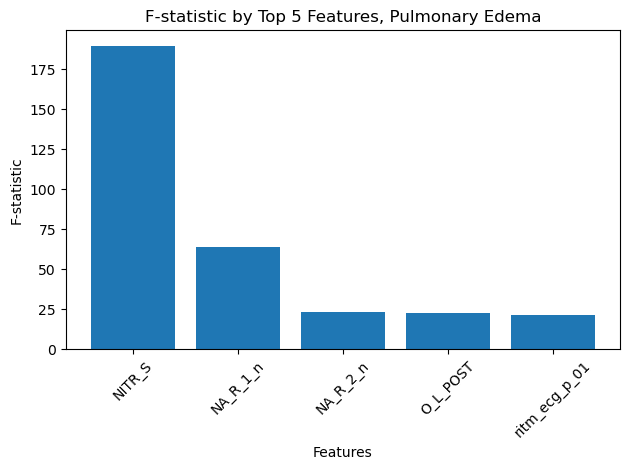

In [27]:
from sklearn.feature_selection import f_classif, mutual_info_classif

X_oh_ord = X[np.concatenate([onehot_ftrs,ordinal_ftrs])] #only onehot and ordinal ftrs because no nans
X_oh_ord.fillna(-1, inplace=True)

# #linear correlations
# for target in target_names:
#     f_stats, p_values = f_classif(X_oh_ord, y_train[target])
#     lin_corr = pd.Series(f_stats, index = X_oh_ord.columns).sort_values(ascending=False)

#     Xf = lin_corr.head(5).index
#     Yf = lin_corr.head(5).values
#     print(max(Yf))

    
#     plt.bar(Xf, Yf)
#     figsize = (4,3)
#     plt.title(f'F-statistic by Top 5 Features, Target = {target}')
#     plt.xticks(rotation=45)
#     plt.xlabel('Features')
#     plt.ylabel('F-statistic')
#     plt.tight_layout()
#     plt.show()

f_stats, p_values = f_classif(X_oh_ord, y['OTEK_LANC'])
lin_corr = pd.Series(f_stats, index = X_oh_ord.columns).sort_values(ascending=False)

Xf = lin_corr.head(5).index
Yf = lin_corr.head(5).values
print(max(Yf))

plt.bar(Xf, Yf)
figsize = (4,3)
plt.title(f'F-statistic by Top 5 Features, Pulmonary Edema')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.show()

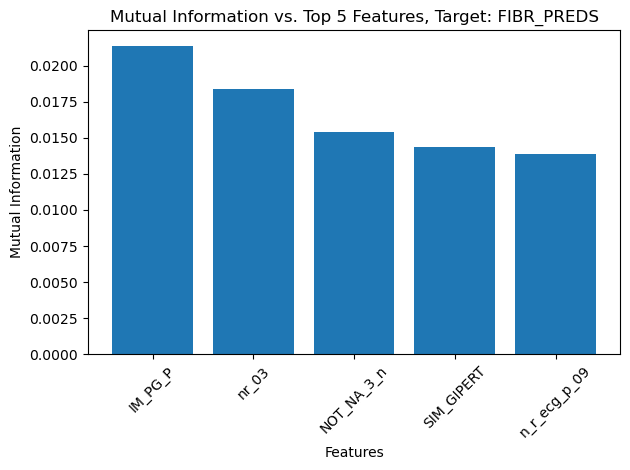

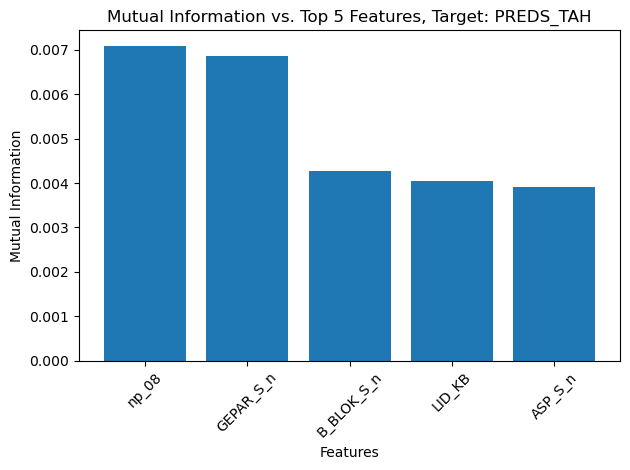

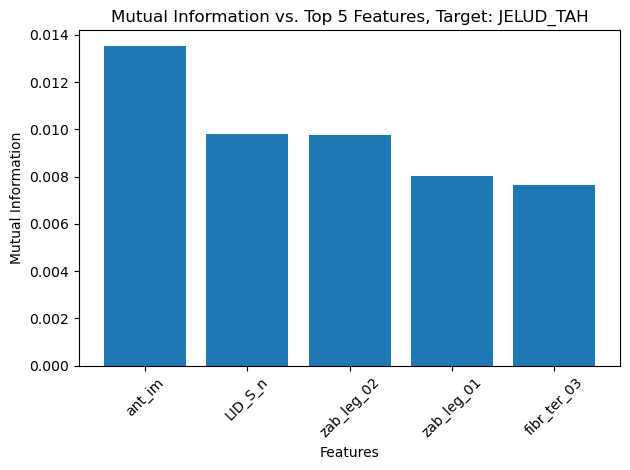

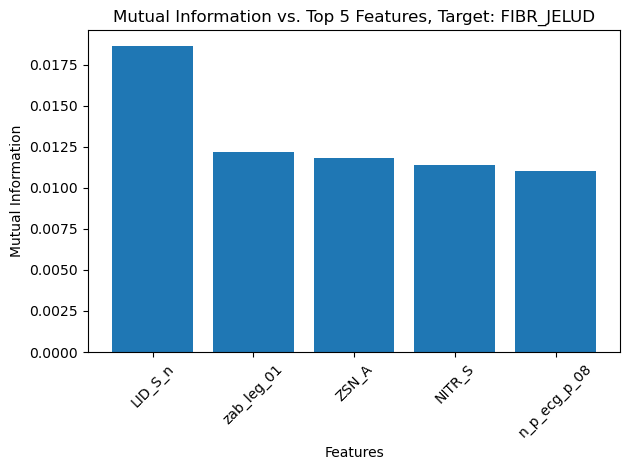

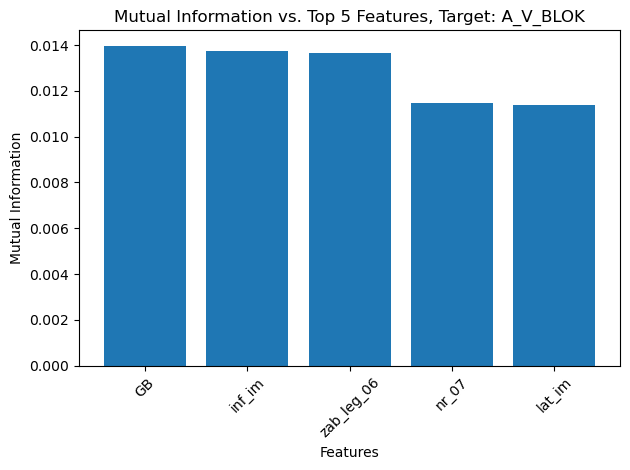

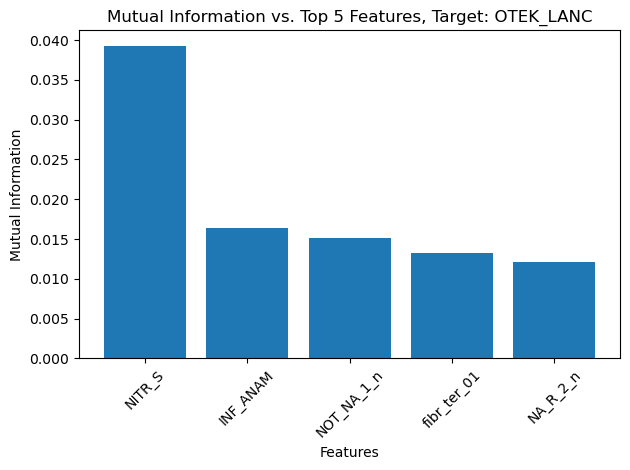

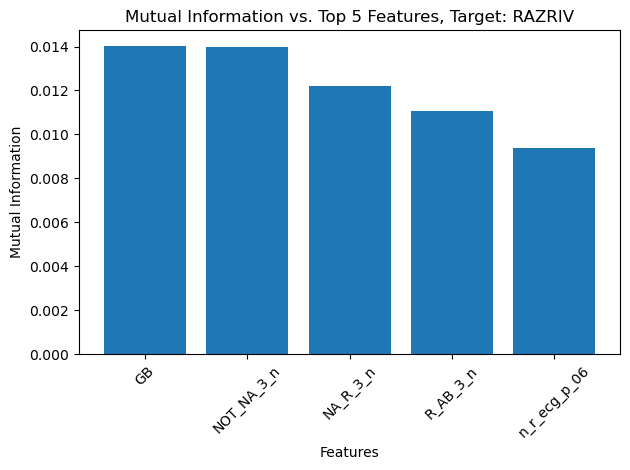

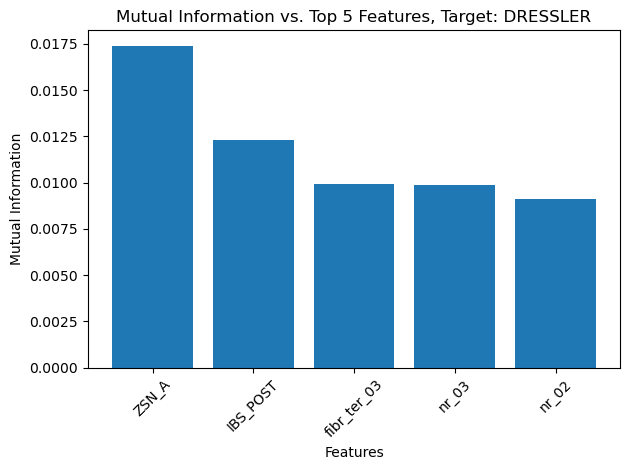

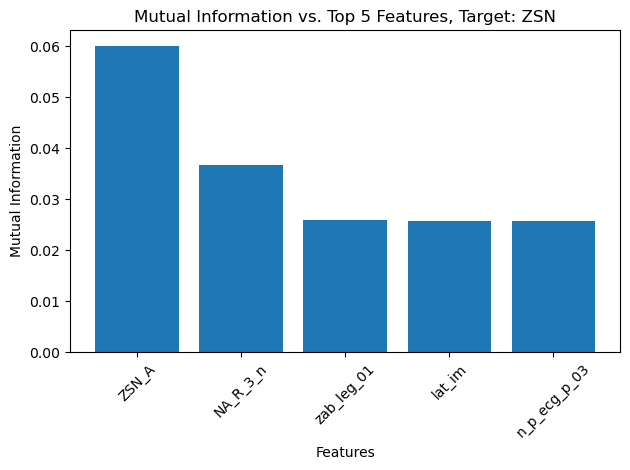

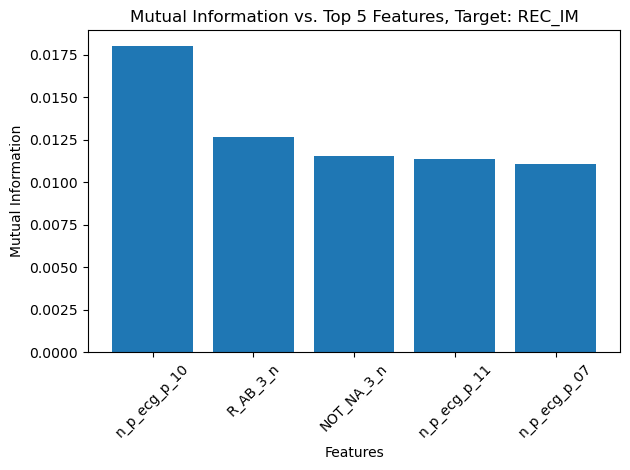

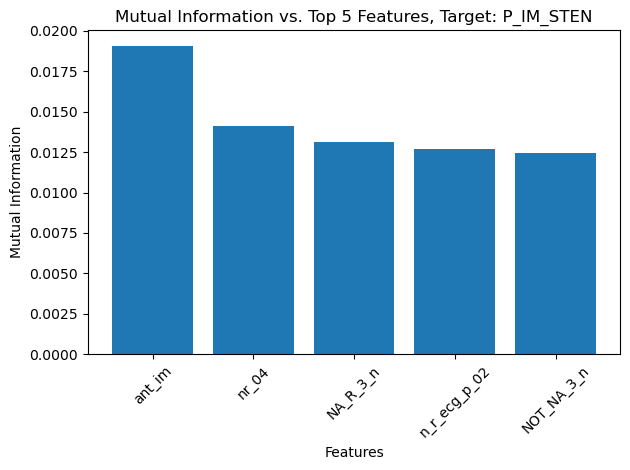

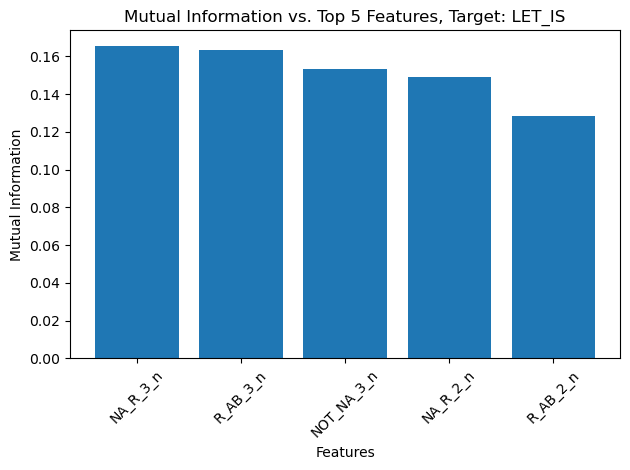

In [28]:

#non-linear correlations
for target in target_names:
    mc = mutual_info_classif(X_oh_ord, y[target])
    non_lin_corr = pd.Series(mc, X_oh_ord.columns).sort_values(ascending=False)

    Xm = non_lin_corr.head(5).index
    Ym = non_lin_corr.head(5).values

    plt.bar(Xm, Ym)
    figsize=(4,3)
    plt.title(f'Mutual Information vs. Top 5 Features, Target: {target}')
    plt.xticks(rotation=45)
    plt.xlabel('Features')
    plt.ylabel('Mutual Information')
    plt.tight_layout()
    plt.show()